In [1]:
import sys
sys.path.append('./Downloads/')

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
visitors = pd.read_csv('Visitors.csv')
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26102 entries, 0 to 26101
Data columns (total 11 columns):
row_number                            26102 non-null int64
visitor_id                            26102 non-null int64
search_timestamp                      26102 non-null object
category                              26102 non-null object
pro_user_id                           26102 non-null int64
num_reviews                           26102 non-null int64
avg_rating                            24947 non-null float64
pro_last_active_time_before_search    25035 non-null object
cost_estimate_cents                   23944 non-null float64
result_position                       26102 non-null int64
service_page_viewed                   26102 non-null bool
dtypes: bool(1), float64(2), int64(5), object(3)
memory usage: 2.0+ MB


In [3]:
contacts = pd.read_csv('Contacts.csv')
contacts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1504 entries, 0 to 1503
Data columns (total 4 columns):
visitor_id     1504 non-null int64
pro_user_id    1504 non-null int64
contact_id     1504 non-null int64
hired          1504 non-null bool
dtypes: bool(1), int64(3)
memory usage: 36.8 KB


### Check for uniqueness

In [4]:
dupe_contact_ids = contacts[contacts.duplicated(subset='contact_id')]['contact_id']
contacts[contacts.contact_id.isin(dupe_contact_ids)]

,visitor_id,pro_user_id,contact_id,hired
677,344116212844240000,312837173627945000,344116540804341000,False
678,344116262351773000,312837173627945000,344116540804341000,False
709,343929038153670000,337420440233549000,343930206911250000,False
953,343107407908708000,208021513578415000,343107763150880000,False
954,343107364725809000,208021513578415000,343107763150880000,False
1365,343929003762401000,337420440233549000,343930206911250000,True


There are a few duplicate contact_ids, so there are some potential data issues with contacts data, but luckily it's miniscule. We can assume visitors is accurate and left join on both visitor_id and pro_user_id and just count contact_id's

## Join contacts and visitors

In [5]:
df = pd.merge(visitors, contacts, how='left', on=['visitor_id','pro_user_id'])
assert(df[df['contact_id'].notnull()]['contact_id'].count() == df[df['contact_id'].notnull()]['service_page_viewed'].count())
assert(df[df['hired']==True]['hired'].count() == df[df['hired']==True]['service_page_viewed'].count())
df['hired'] = df['hired'].fillna(value=False) #replace n/a with False

## Some feature manipulation/cleaning

In [6]:
df['search_timestamp'] = pd.to_datetime(df['search_timestamp'])
df['pro_last_active_time_before_search'] = pd.to_datetime(df['pro_last_active_time_before_search'])

df = df[df['pro_last_active_time_before_search'].notnull()]

^Decided to drop rows where pro last active time is n/a because this could be some data logging issue. It's only a small amount of the data and will make running the model smoother.

In [7]:
df['last_active_hours'] = (df['search_timestamp'] - df['pro_last_active_time_before_search']).dt.ceil('h')
df['last_active_hours'] = df['last_active_hours'].fillna(0)
df['last_active_hours'] = df['last_active_hours']/ np.timedelta64(1, 'h')

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Passing integers to fillna is deprecated, will raise a TypeError in a future version.  To retain the old behavior, pass pd.Timedelta(seconds=n) instead.
  


In [8]:
df['avg_rating_rounded'] = df['avg_rating'].round(1)
df['cost_estimate_dollars'] = df['cost_estimate_cents'] / 100

### Split Moving vs Cleaning categories

In [9]:
moving = df[df['category']=='Local Moving (under 50 miles)']
cleaning = df[df['category']=='House Cleaning']

# Moving

## Conversion Funnel

In [10]:
moving_totals = {'searches' : moving['row_number'].count(),
                  'page_views' : moving['service_page_viewed'].sum(),
                  'contacts' : moving['contact_id'].count(),
                  'hires' : moving['hired'].sum()}

moving_overall = pd.DataFrame.from_dict(moving_totals,
                                         orient='index',
                                         columns=['count'])

moving_overall['%_of_searches'] = moving_overall['count'] / moving_totals['searches']
moving_overall

,count,%_of_searches
searches,6886,1.000000
page_views,915,0.132878
contacts,690,0.100203
hires,154,0.022364


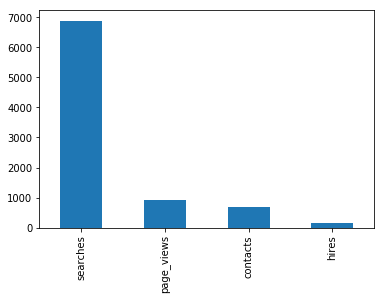

In [11]:
moving_overall['count'].plot(kind='bar')

### Aggregate conversion rates by step in the funnel

In [12]:
moving_by_step_dict = {'page_view_per_search' : moving['service_page_viewed'].sum() / moving['row_number'].count(),
                        'contacts_per_page_view' : moving['contact_id'].count() / moving['service_page_viewed'].sum(),
                        'hires_per_contact' : moving['hired'].sum() / moving['contact_id'].count()}

moving_by_step = pd.DataFrame.from_dict(moving_by_step_dict,
                                      orient='index',
                                      columns=['%'])
moving_by_step

,%
page_view_per_search,0.132878
contacts_per_page_view,0.754098
hires_per_contact,0.223188


### Proportion of users

In [13]:
moving_proportions = {'%_of_users_search':moving[moving['row_number'].notnull()]['visitor_id'].nunique() / moving['visitor_id'].nunique(),
                       '%_of_users_view_page':moving[moving['service_page_viewed']==True]['visitor_id'].nunique() / moving['visitor_id'].nunique(),
                       '%_of_users_contact':moving[moving['contact_id'].notnull()]['visitor_id'].nunique() / moving['visitor_id'].nunique(),
                       '%_of_users_hire':moving[moving['hired']==True]['visitor_id'].nunique() / moving['visitor_id'].nunique()}

moving_proportions = pd.DataFrame.from_dict(moving_proportions,
                                             orient='index',
                                             columns=['%'])
moving_proportions

,%
%_of_users_search,1.000000
%_of_users_view_page,0.506545
%_of_users_contact,0.446990
%_of_users_hire,0.098822


### Group by pro and user

In [14]:
moving_by_pro = moving.groupby('pro_user_id').agg({'row_number':'count',
                                                   'service_page_viewed':'sum',
                                                   'contact_id':'count',
                                                   'hired':'sum',
                                                   'last_active_hours':'mean',
                                                   'num_reviews':'mean',
                                                   'avg_rating': 'mean',
                                                   'cost_estimate_dollars': 'mean',
                                                   'result_position': 'mean'}).reset_index()\
                                                   .sort_values('contact_id', ascending=False)
moving_by_pro.head(10)

,pro_user_id,row_number,service_page_viewed,contact_id,hired,last_active_hours,num_reviews,avg_rating,cost_estimate_dollars,result_position
67,216853500423259000,59,26.0,22,5.0,5.762712,362.915254,4.446339,95.000000,1.610169
178,273470080930079000,69,26.0,19,3.0,3.840580,654.101449,4.758290,97.898551,1.304348
156,263666245073364000,33,16.0,15,4.0,8.818182,416.151515,4.604893,95.151515,1.000000
123,247671360295322000,38,16.0,14,1.0,5.394737,96.868421,4.679973,87.236842,1.105263
105,239807985459807000,43,18.0,14,3.0,7.860465,499.046512,4.459153,79.000000,1.325581
226,293913182938849000,40,12.0,11,5.0,10.300000,116.875000,4.768973,79.750000,1.500000
408,333743292806455000,24,12.0,10,3.0,4.666667,28.250000,4.655701,85.000000,1.000000
126,249753733673108000,49,16.0,10,2.0,10.040816,287.306122,4.519675,83.285714,1.040816
181,276622949070103000,44,11.0,10,2.0,7.886364,230.181818,4.823992,89.000000,1.522727
164,268080096863781000,70,11.0,10,4.0,3.214286,209.928571,4.375291,89.000000,1.928571


In [15]:
moving_by_user = moving.groupby('visitor_id').agg({'row_number':'count',
                                                   'service_page_viewed':'sum',
                                                   'contact_id':'count',
                                                   'hired':'sum',
                                                   'last_active_hours':'mean',
                                                   'num_reviews':'mean',
                                                   'avg_rating': 'mean',
                                                   'cost_estimate_dollars': 'mean',
                                                   'result_position': 'mean'}).reset_index()\
                                                   .sort_values('contact_id', ascending=False)
moving_by_user.head(10)

,visitor_id,row_number,service_page_viewed,contact_id,hired,last_active_hours,num_reviews,avg_rating,cost_estimate_dollars,result_position
301,343071849291628000,4,1.0,2,0.0,12.250000,137.000000,4.769412,89.500000,2.5
695,343492100068655000,12,4.0,2,2.0,81.416667,254.333333,4.622639,83.800000,6.5
1207,344128990755184000,8,3.0,2,0.0,73.500000,25.000000,4.923007,91.625000,4.5
846,343595399668547000,3,2.0,2,1.0,15.000000,174.000000,4.886113,98.000000,2.0
554,343323274585923000,6,1.0,2,0.0,52.166667,81.166667,4.679726,86.800000,3.5
226,342991334567977000,13,3.0,2,2.0,110.000000,94.615385,4.743393,116.769231,7.0
824,343587214384390000,2,2.0,2,2.0,22.000000,54.500000,4.542832,77.500000,1.5
546,343311410731663000,4,1.0,1,0.0,15.500000,35.250000,4.388826,148.750000,2.5
1206,344128879488876000,4,1.0,1,0.0,16.500000,150.250000,4.072576,116.000000,2.5
581,343337408425934000,5,1.0,1,0.0,172.200000,158.000000,4.606072,123.000000,3.0


In [16]:
moving['visitor_id'].nunique()

1528

In [17]:
moving['pro_user_id'].nunique()

590

In [18]:
user_distribution = moving_by_user.groupby(['contact_id','hired'])['visitor_id'].count().reset_index()
user_distribution = user_distribution[user_distribution['contact_id']>0]
user_distribution['%_of_visitors'] = user_distribution['visitor_id']/user_distribution['visitor_id'].sum()
user_distribution

,contact_id,hired,visitor_id,%_of_visitors
1,1,0.0,529,0.774524
2,1,1.0,147,0.215227
3,2,0.0,3,0.004392
4,2,1.0,1,0.001464
5,2,2.0,3,0.004392


## Exploratory Analysis of each variable

### avg_rating

In [19]:
moving[moving['avg_rating'].isnull()]['num_reviews'].unique() # validate if avg_rating is null, num_reviews is 0

array([0])

In [20]:
moving[moving['num_reviews']==0]['avg_rating'].unique() # vice versa

array([nan])

In [21]:
moving['avg_rating'].describe()

count    6730.000000
mean        4.623321
std         0.405344
min         1.000000
25%         4.500000
50%         4.692308
75%         4.902439
max         5.000000
Name: avg_rating, dtype: float64

In [22]:
def summarize_metric(df, metric, ascending=False):
    metric_df = df.groupby(metric).agg({'row_number':'count',
                                        'service_page_viewed':'sum',
                                        'contact_id':'count',
                                        'hired':'sum'}).reset_index()

    metric_df['%_of_searches'] = metric_df['row_number']/ metric_df['row_number'].sum()
    metric_df['%_of_page_views'] = metric_df['service_page_viewed']/ metric_df['service_page_viewed'].sum()
    metric_df['%_of_contacts'] = metric_df['contact_id']/ metric_df['contact_id'].sum()
    metric_df['%_of_hires'] = metric_df['hired']/ metric_df['hired'].sum()

    metric_df['page_view_per_search'] = metric_df['service_page_viewed'] / metric_df['row_number']
    metric_df['contact_per_search'] = metric_df['contact_id'] / metric_df['row_number']
    metric_df['contact_per_page_view'] = metric_df['contact_id'] / metric_df['service_page_viewed']
    metric_df['hire_per_search'] = metric_df['hired'] / metric_df['row_number']
    metric_df['hire_per_contact'] = metric_df['hired'] / metric_df['contact_id']

    return metric_df.sort_values(metric, ascending=ascending)

In [23]:
avg_rating = summarize_metric(moving, 'avg_rating_rounded')
avg_rating

,avg_rating_rounded,row_number,service_page_viewed,contact_id,hired,%_of_searches,%_of_page_views,%_of_contacts,%_of_hires,page_view_per_search,contact_per_search,contact_per_page_view,hire_per_search,hire_per_contact
21,5.0,1496,143.0,103,19.0,0.222288,0.156455,0.149492,0.123377,0.095588,0.068850,0.720280,0.012701,0.184466
20,4.9,672,94.0,73,19.0,0.099851,0.102845,0.105951,0.123377,0.139881,0.108631,0.776596,0.028274,0.260274
19,4.8,774,150.0,113,28.0,0.115007,0.164114,0.164006,0.181818,0.193798,0.145995,0.753333,0.036176,0.247788
18,4.7,854,149.0,117,20.0,0.126895,0.163020,0.169811,0.129870,0.174473,0.137002,0.785235,0.023419,0.170940
17,4.6,819,109.0,84,17.0,0.121694,0.119256,0.121916,0.110390,0.133089,0.102564,0.770642,0.020757,0.202381
16,4.5,601,113.0,86,20.0,0.089302,0.123632,0.124819,0.129870,0.188020,0.143095,0.761062,0.033278,0.232558
15,4.4,447,72.0,52,16.0,0.066419,0.078775,0.075472,0.103896,0.161074,0.116331,0.722222,0.035794,0.307692
14,4.3,215,27.0,23,4.0,0.031947,0.029540,0.033382,0.025974,0.125581,0.106977,0.851852,0.018605,0.173913
13,4.2,223,26.0,20,6.0,0.033135,0.028446,0.029028,0.038961,0.116592,0.089686,0.769231,0.026906,0.300000
12,4.1,90,8.0,6,2.0,0.013373,0.008753,0.008708,0.012987,0.088889,0.066667,0.750000,0.022222,0.333333


### Searches, Pageviews, Contacts, Hires by avg_rating

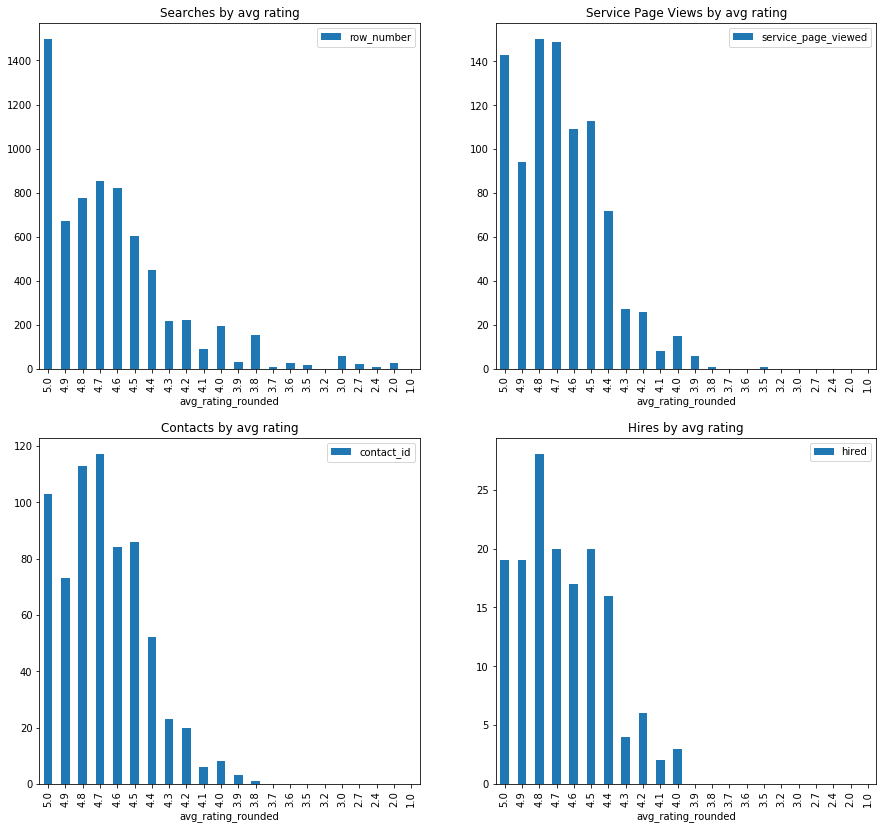

In [24]:
fig, axes = plt.subplots(2,2, figsize=(15,14))

avg_rating[['avg_rating_rounded','row_number']].plot(kind='bar',
                                                     x='avg_rating_rounded',
                                                     y='row_number',
                                                     ax=axes[0,0],
                                                     title='Searches by avg rating')

avg_rating[['avg_rating_rounded','service_page_viewed']].plot(kind='bar',
                                                              x='avg_rating_rounded',
                                                              y='service_page_viewed',
                                                              ax=axes[0,1],
                                                              title='Service Page Views by avg rating')

avg_rating[['avg_rating_rounded','contact_id']].plot(kind='bar',
                                                     x='avg_rating_rounded',
                                                     y='contact_id',
                                                     ax=axes[1,0],
                                                     title='Contacts by avg rating')

avg_rating[['avg_rating_rounded','hired']].plot(kind='bar',
                                                x='avg_rating_rounded',
                                                y='hired',
                                                ax=axes[1,1],
                                                title='Hires by avg rating')

### Contact rate (contacts/searches) by avg_rating

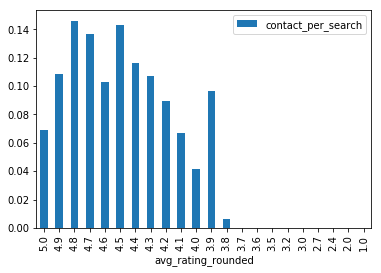

In [25]:
avg_rating[['avg_rating_rounded','contact_per_search']].plot(kind='bar',
                                                             x='avg_rating_rounded',
                                                             y='contact_per_search')

### Cost Estimate

In [26]:
moving['cost_estimate_dollars'].describe()

count    6302.000000
mean      102.431768
std        33.864350
min         8.000000
25%        85.000000
50%        95.000000
75%       110.000000
max       297.000000
Name: cost_estimate_dollars, dtype: float64

In [27]:
moving_cost = summarize_metric(moving, 'cost_estimate_dollars', ascending=True)
cost_bins = [i for i in range(0, 300, 5)]

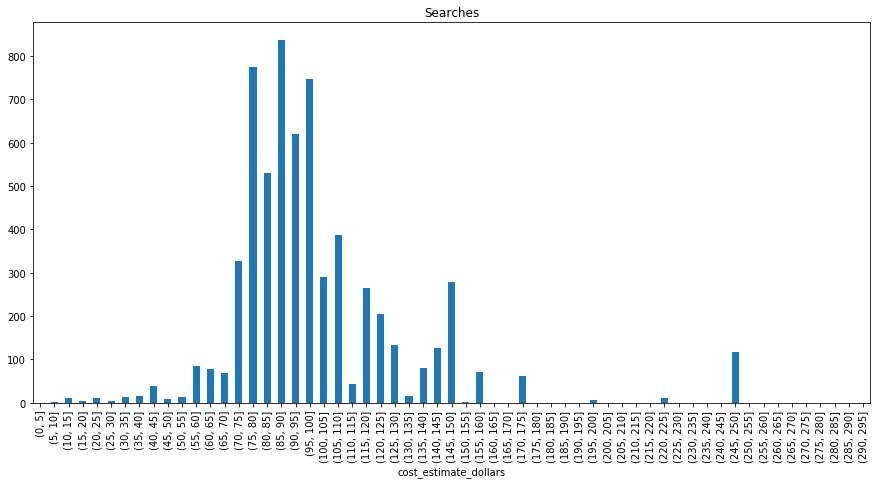

In [28]:
moving_searches = moving_cost.groupby(pd.cut(moving_cost['cost_estimate_dollars'], bins=cost_bins)).row_number.sum()
moving_searches.plot(kind='bar', figsize=(15,7), title='Searches')

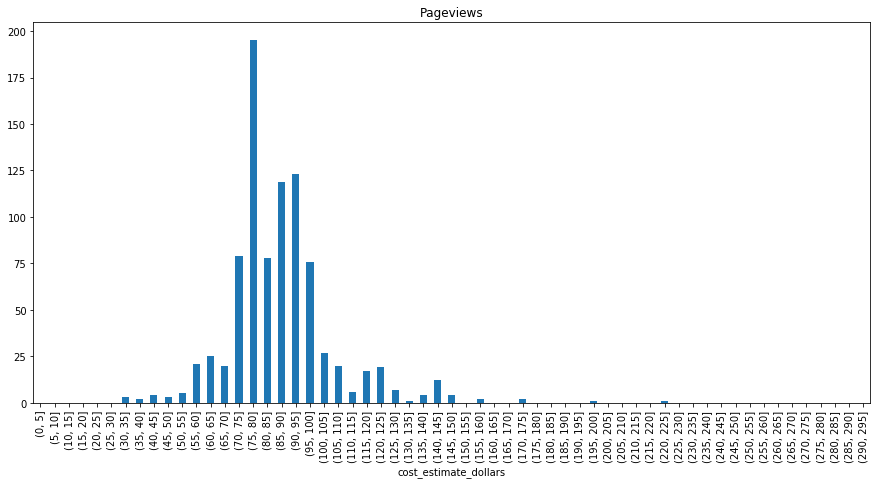

In [29]:
moving_page_views = moving_cost.groupby(pd.cut(moving_cost['cost_estimate_dollars'], bins=cost_bins)).service_page_viewed.sum()
moving_page_views.plot(kind='bar', figsize=(15,7), title='Pageviews')

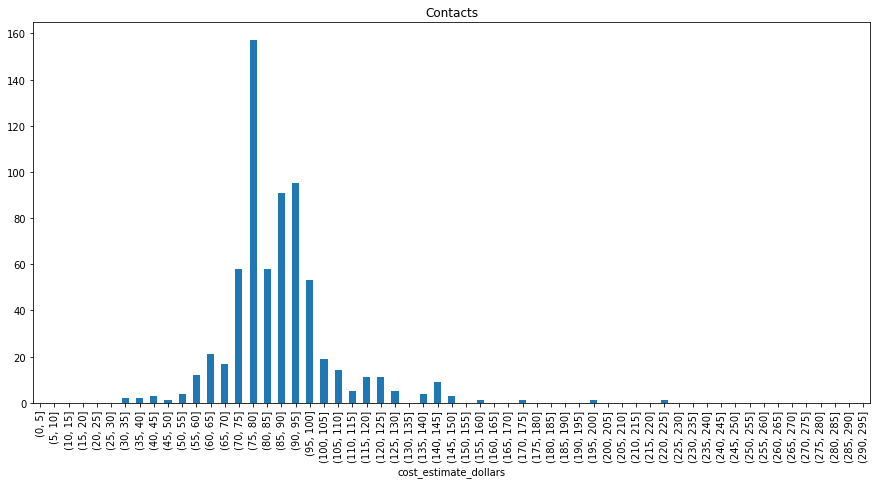

In [30]:
moving_contacts = moving_cost.groupby(pd.cut(moving_cost['cost_estimate_dollars'], bins=cost_bins)).contact_id.sum()
moving_contacts.plot(kind='bar', figsize=(15,7), title='Contacts')

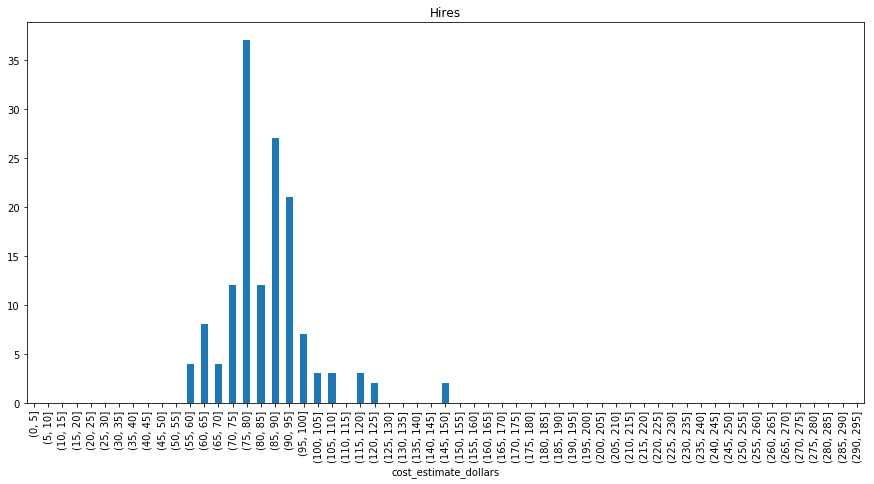

In [31]:
moving_hires = moving_cost.groupby(pd.cut(moving_cost['cost_estimate_dollars'], bins=cost_bins)).hired.sum()
moving_hires.plot(kind='bar', figsize=(15,7), title='Hires')

### result position

In [32]:
moving['result_position'].describe()

count    6886.000000
mean        3.765757
std         2.866053
min         1.000000
25%         2.000000
50%         3.000000
75%         5.000000
max        20.000000
Name: result_position, dtype: float64

In [33]:
moving['result_position'].isnull().sum()

0

In [34]:
moving_result_position = summarize_metric(moving, 'result_position', ascending=True)

### Counts by result_position

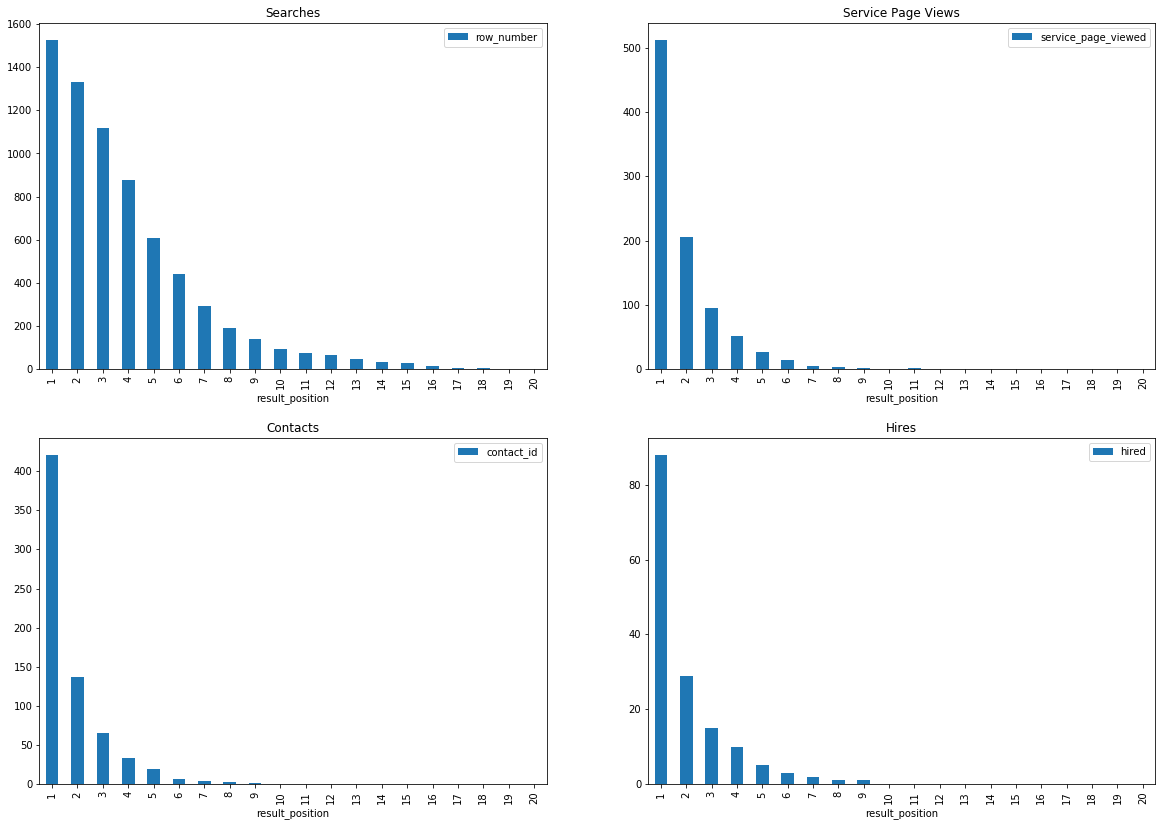

In [35]:
fig, axes = plt.subplots(2,2, figsize=(20,14))


moving_result_position[['result_position','row_number']].plot(kind='bar',
                                                             x='result_position',
                                                             y='row_number',
                                                             ax=axes[0,0],
                                                             title='Searches')

moving_result_position[['result_position','service_page_viewed']].plot(kind='bar',
                                                                      x='result_position',
                                                                      y='service_page_viewed',
                                                                      ax=axes[0,1],
                                                                      title='Service Page Views')

moving_result_position[['result_position','contact_id']].plot(kind='bar',
                                                             x='result_position',
                                                             y='contact_id',
                                                             ax=axes[1,0],
                                                             title='Contacts')

moving_result_position[['result_position','hired']].plot(kind='bar',
                                                        x='result_position',
                                                        y='hired',
                                                        ax=axes[1,1],
                                                        title='Hires')

### Rates by result_position

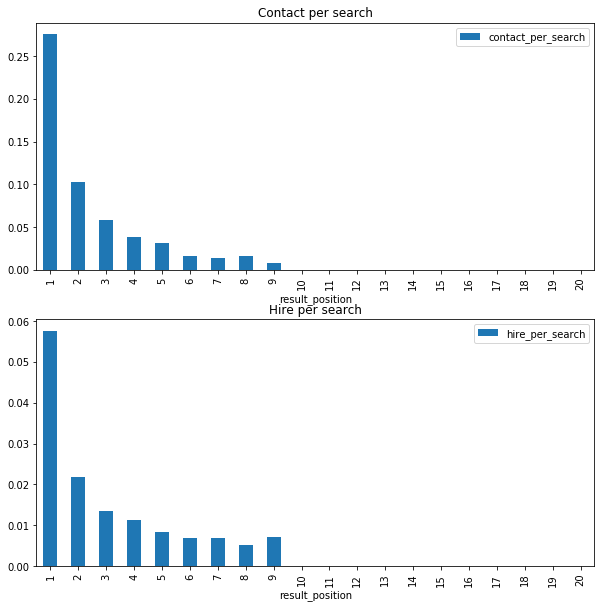

In [36]:
fig, axes = plt.subplots(2,1, figsize=(10,10))

moving_result_position[['result_position','contact_per_search']].plot(kind='bar',
                                                     x='result_position',
                                                     y='contact_per_search',
                                                     ax=axes[0],
                                                     title='Contact per search')

moving_result_position[['result_position','hire_per_search']].plot(kind='bar',
                                                     x='result_position',
                                                     y='hire_per_search',
                                                     ax=axes[1],
                                                     title='Hire per search')

### Responsiveness (in hours)

In [37]:
moving['last_active_hours'].describe()

count     6886.000000
mean        97.484316
std        504.362295
min          1.000000
25%          3.000000
50%         13.000000
75%         42.000000
max      22671.000000
Name: last_active_hours, dtype: float64

In [38]:
moving_last_active_hours = summarize_metric(moving, 'last_active_hours', ascending=True)
moving_last_active_hours

,last_active_hours,row_number,service_page_viewed,contact_id,hired,%_of_searches,%_of_page_views,%_of_contacts,%_of_hires,page_view_per_search,contact_per_search,contact_per_page_view,hire_per_search,hire_per_contact
0,1.0,813,151.0,122,29.0,0.118066,0.165027,0.176812,0.188312,0.185732,0.150062,0.807947,0.035670,0.237705
1,2.0,567,111.0,90,17.0,0.082341,0.121311,0.130435,0.110390,0.195767,0.158730,0.810811,0.029982,0.188889
2,3.0,432,85.0,60,12.0,0.062736,0.092896,0.086957,0.077922,0.196759,0.138889,0.705882,0.027778,0.200000
3,4.0,318,50.0,45,11.0,0.046181,0.054645,0.065217,0.071429,0.157233,0.141509,0.900000,0.034591,0.244444
4,5.0,257,33.0,23,6.0,0.037322,0.036066,0.033333,0.038961,0.128405,0.089494,0.696970,0.023346,0.260870
5,6.0,216,40.0,27,1.0,0.031368,0.043716,0.039130,0.006494,0.185185,0.125000,0.675000,0.004630,0.037037
6,7.0,129,13.0,12,5.0,0.018734,0.014208,0.017391,0.032468,0.100775,0.093023,0.923077,0.038760,0.416667
7,8.0,154,21.0,14,2.0,0.022364,0.022951,0.020290,0.012987,0.136364,0.090909,0.666667,0.012987,0.142857
8,9.0,112,16.0,12,0.0,0.016265,0.017486,0.017391,0.000000,0.142857,0.107143,0.750000,0.000000,0.000000
9,10.0,110,12.0,7,0.0,0.015974,0.013115,0.010145,0.000000,0.109091,0.063636,0.583333,0.000000,0.000000


In [39]:
moving_last_active_hours[moving_last_active_hours['last_active_hours'] <= 13]['%_of_page_views'].sum()

0.6349726775956285

### number of reviews

In [40]:
moving['num_reviews'].describe()

count    6886.000000
mean      114.502904
std       179.266221
min         0.000000
25%         9.000000
50%        30.000000
75%       133.000000
max       997.000000
Name: num_reviews, dtype: float64

In [41]:
moving_num_reviews = summarize_metric(moving, 'num_reviews')
review_bins = [i for i in range(0, 1000, 10)]

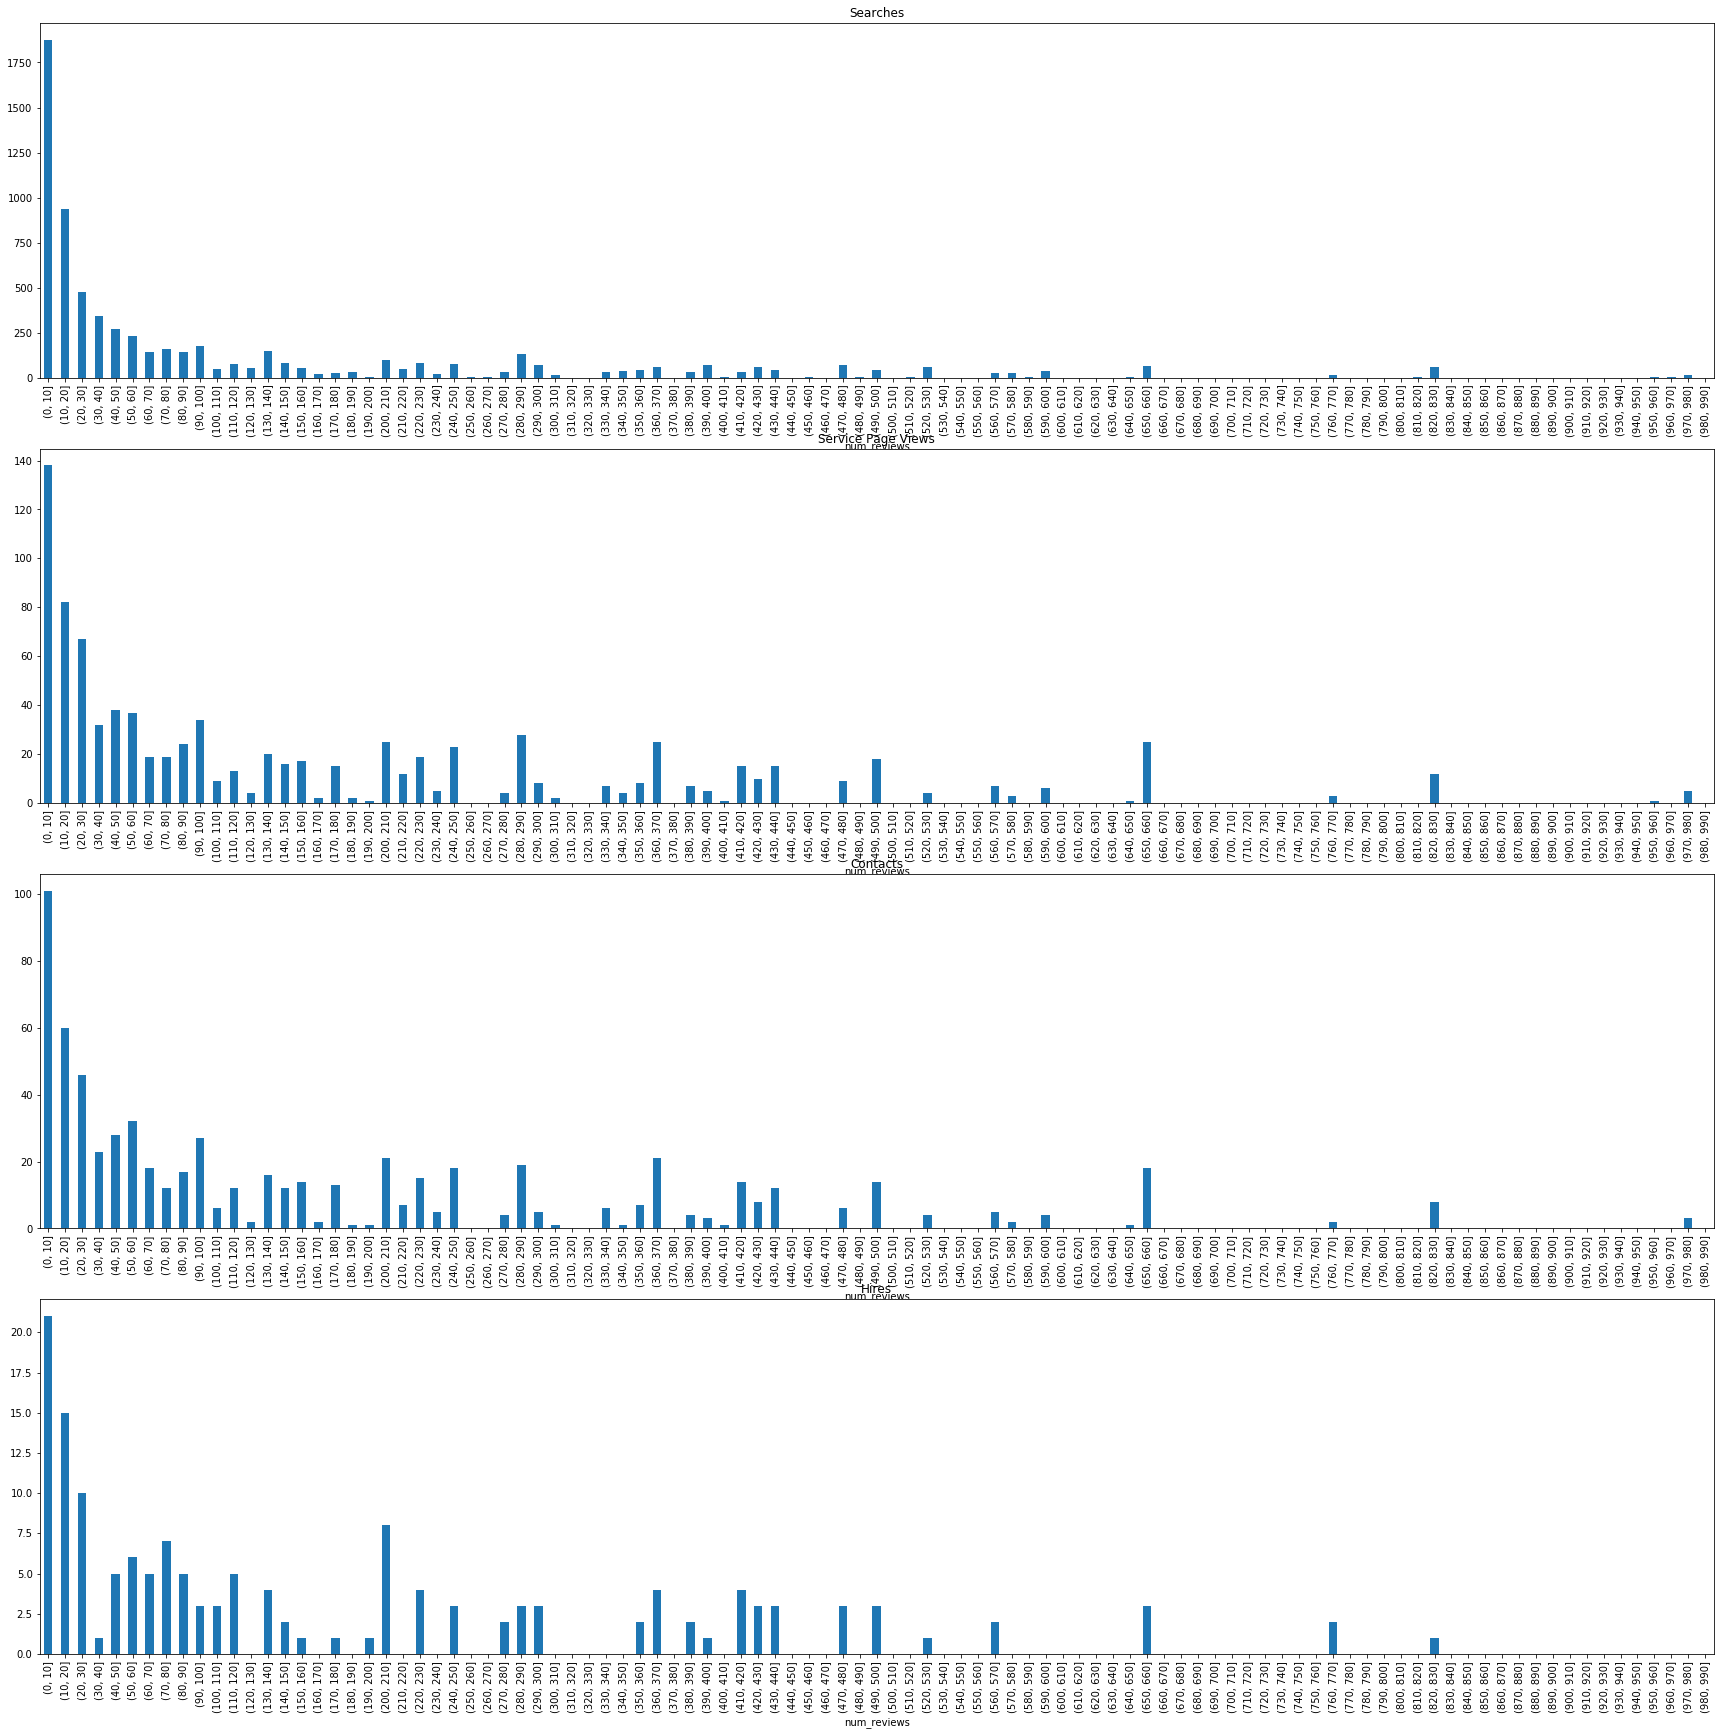

In [42]:
fig, axes = plt.subplots(4,1, figsize=(30,30))

moving_searches = moving_num_reviews.groupby(pd.cut(moving_num_reviews['num_reviews'], bins=review_bins)).row_number.sum()
moving_searches.plot(kind='bar', ax=axes[0], title='Searches')

moving_page_views = moving_num_reviews.groupby(pd.cut(moving_num_reviews['num_reviews'], bins=review_bins)).service_page_viewed.sum()
moving_page_views.plot(kind='bar', ax=axes[1], title='Service Page Views')

moving_contacts = moving_num_reviews.groupby(pd.cut(moving_num_reviews['num_reviews'], bins=review_bins)).contact_id.sum()
moving_contacts.plot(kind='bar', ax=axes[2], title='Contacts')

moving_hires = moving_num_reviews.groupby(pd.cut(moving_num_reviews['num_reviews'], bins=review_bins)).hired.sum()
moving_hires.plot(kind='bar', ax=axes[3], title='Hires')


In [43]:
moving_num_reviews[moving_num_reviews['num_reviews'] >= 30]['%_of_contacts'].sum()

0.7014492753623189

### Data Modeling - Hires

In [44]:
hired = moving['hired']

In [45]:
features = moving[[ 'num_reviews',
                    'avg_rating',
                    'cost_estimate_dollars',
                    'result_position',
                    'last_active_hours']].fillna(0)

In [46]:
X_train, X_test, y_train, y_test = train_test_split(features, hired,train_size = 0.8, random_state = 0)
rfc = RandomForestClassifier(n_estimators=10)
rfc_model = rfc.fit(X_train, y_train)
rfc_predictions = rfc_model.predict(X_test)

def scores(test_set, predictions):
    print('Accuracy score: {}'.format(accuracy_score(test_set,predictions)))
    print('F1 score: {}'.format(f1_score(test_set,predictions,average=None)))
    print('Precision score: {}'.format(precision_score(test_set,predictions,average=None)))
    print('Recall score: {}'.format(recall_score(test_set,predictions,average=None)))
    
scores(y_test, rfc_predictions)

Accuracy score: 0.9702467343976778
F1 score: [0.98488758 0.04651163]
Precision score: [0.9773226  0.09090909]
Recall score: [0.99257058 0.03125   ]


/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [47]:
feature_importances = pd.DataFrame(rfc.feature_importances_,
                                   index = X_train.columns,
                                   columns=['importance']).sort_values('importance',ascending=False)
feature_importances

,importance
last_active_hours,0.358180
num_reviews,0.250806
avg_rating,0.208516
cost_estimate_dollars,0.111685
result_position,0.070814


### Contacts

In [48]:
contacts = moving['contact_id'].notnull()

In [49]:
X_train, X_test, y_train, y_test = train_test_split(features, contacts, train_size = 0.8)
rfc = RandomForestClassifier(n_estimators=10)
rfc_model = rfc.fit(X_train, y_train)
rfc_predictions = rfc_model.predict(X_test)
scores(y_test, rfc_predictions)
feature_importances = pd.DataFrame(rfc.feature_importances_,
                                   index = X_train.columns,
                                   columns=['importance']).sort_values('importance',ascending=False)
feature_importances

Accuracy score: 0.8693759071117562
F1 score: [0.92902208 0.18181818]
Precision score: [0.90130069 0.28169014]
Recall score: [0.95850285 0.13422819]


/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


,importance
last_active_hours,0.320015
num_reviews,0.220113
avg_rating,0.188157
cost_estimate_dollars,0.136695
result_position,0.135019


### Pageviews

In [50]:
pageviews = moving['service_page_viewed']

In [51]:
X_train, X_test, y_train, y_test = train_test_split(features, pageviews, train_size = 0.8)
rfc = RandomForestClassifier(n_estimators=10)
rfc_model = rfc.fit(X_train, y_train)
rfc_predictions = rfc_model.predict(X_test)
scores(y_test, rfc_predictions)
feature_importances = pd.DataFrame(rfc.feature_importances_,
                                   index = X_train.columns,
                                   columns=['importance']).sort_values('importance',ascending=False)
feature_importances

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Accuracy score: 0.8345428156748912
F1 score: [0.90716612 0.24      ]
Precision score: [0.87647522 0.3364486 ]
Recall score: [0.94008439 0.1865285 ]


,importance
last_active_hours,0.328263
num_reviews,0.209877
avg_rating,0.184631
result_position,0.150148
cost_estimate_dollars,0.127080


# Cleaning Pros

In [52]:
cleaning_totals = {'searches' : cleaning['row_number'].count(),
                  'page_views' : cleaning['service_page_viewed'].sum(),
                  'contacts' : cleaning['contact_id'].count(),
                  'hires' : cleaning['hired'].sum()}

cleaning_overall = pd.DataFrame.from_dict(cleaning_totals,
                                         orient='index',
                                         columns=['count'])
cleaning_overall['%_of_searches'] = cleaning_overall['count'] / cleaning_totals['searches']
cleaning_overall

,count,%_of_searches
searches,18149,1.000000
page_views,1260,0.069425
contacts,793,0.043694
hires,204,0.011240


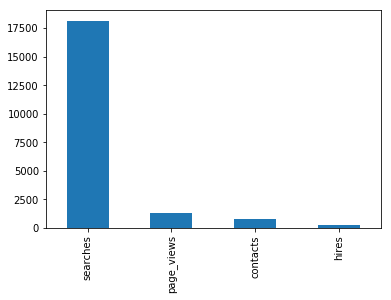

In [53]:
cleaning_overall['count'].plot(kind='bar')

### Proportion of users

In [54]:
cleaning_proportions = {'%_of_users_search':cleaning[cleaning['row_number'].notnull()]['visitor_id'].nunique() / cleaning['visitor_id'].nunique(),
                       '%_of_users_view_page':cleaning[cleaning['service_page_viewed']==True]['visitor_id'].nunique() / cleaning['visitor_id'].nunique(),
                       '%_of_users_contact':cleaning[cleaning['contact_id'].notnull()]['visitor_id'].nunique() / cleaning['visitor_id'].nunique(),
                       '%_of_users_hire':cleaning[cleaning['hired']==True]['visitor_id'].nunique() / cleaning['visitor_id'].nunique()}

cleaning_proportions = pd.DataFrame.from_dict(cleaning_proportions,
                                     orient='index',
                                     columns=['%'])
cleaning_proportions

,%
%_of_users_search,1.000000
%_of_users_view_page,0.494955
%_of_users_contact,0.409984
%_of_users_hire,0.107807


In [55]:
cleaning_by_step_dict = {'page_view_per_search' : cleaning['service_page_viewed'].sum() / cleaning['row_number'].count(),
                        'contacts_per_page_view' : cleaning['contact_id'].count() / cleaning['service_page_viewed'].sum(),
                        'hires_per_contact' : cleaning['hired'].sum() / cleaning['contact_id'].count()}

cleaning_by_step = pd.DataFrame.from_dict(cleaning_by_step_dict,
                                  orient='index',
                                  columns=['%'])
cleaning_by_step

,%
page_view_per_search,0.069425
contacts_per_page_view,0.629365
hires_per_contact,0.257251


### Group by pro, customer

In [56]:
cleaning_by_pro = cleaning.groupby('pro_user_id').agg({'row_number':'count',
                                   'service_page_viewed':'sum',
                                   'contact_id':'count',
                                   'hired':'sum',
                                   'last_active_hours':'mean',
                                   'num_reviews':'mean',
                                   'avg_rating': 'mean',
                                   'cost_estimate_dollars': 'mean',
                                   'result_position': 'mean'}).reset_index()\
                                   .sort_values('contact_id', ascending=False)
cleaning_by_pro.head(10)

,pro_user_id,row_number,service_page_viewed,contact_id,hired,last_active_hours,num_reviews,avg_rating,cost_estimate_dollars,result_position
1096,302399988312342000,45,10.0,9,1.0,7.244444,113.644444,4.821696,94.533333,1.733333
456,242310665917301000,22,8.0,8,3.0,8.909091,109.863636,4.863451,147.181818,2.272727
1262,309622600675197000,32,10.0,8,1.0,3.656250,207.531250,4.655675,97.718750,1.156250
883,287646262513263000,26,11.0,8,2.0,4.653846,190.192308,4.788659,109.538462,1.192308
65,165781621571519000,25,12.0,7,2.0,5.720000,594.680000,4.469904,74.400000,1.120000
770,277233537620091000,34,9.0,7,0.0,114.323529,101.794118,4.858725,94.029412,1.500000
166,198869800397579000,31,7.0,6,3.0,5.290323,133.225806,4.421342,173.333333,3.096774
1979,334376230517481000,34,7.0,6,0.0,12.470588,30.764706,4.769742,87.911765,2.617647
171,200067687694935000,32,8.0,6,2.0,3.781250,241.468750,4.693774,121.129032,2.281250
50,136166152851137000,17,7.0,5,1.0,8.764706,203.529412,4.266792,136.764706,1.117647


In [57]:
cleaning['visitor_id'].nunique()

1883

In [58]:
cleaning['pro_user_id'].nunique()

2787

In [59]:
cleaning_by_user = cleaning.groupby('visitor_id').agg({'row_number':'count',
                                                   'service_page_viewed':'sum',
                                                   'contact_id':'count',
                                                   'hired':'sum',
                                                   'last_active_hours':'mean',
                                                   'num_reviews':'mean',
                                                   'avg_rating': 'mean',
                                                   'cost_estimate_dollars': 'mean',
                                                   'result_position': 'mean'}).reset_index()\
                                                   .sort_values('contact_id', ascending=False)
cleaning_by_user.head(10)

cleaning_by_user = cleaning_by_user.groupby(['contact_id','hired'])['visitor_id'].count().reset_index()
cleaning_by_user = cleaning_by_user[cleaning_by_user['contact_id'] > 0]
cleaning_by_user['%_of_visitors'] = cleaning_by_user['visitor_id']/cleaning_by_user['visitor_id'].sum()
cleaning_by_user

,contact_id,hired,visitor_id,%_of_visitors
1,1,0.0,554,0.717617
2,1,1.0,199,0.257772
3,2,0.0,13,0.016839
4,2,1.0,3,0.003886
5,2,2.0,1,0.001295
6,3,0.0,2,0.002591


## Exploratory Data Analysis by variable

### avg_rating

In [60]:
cleaning[cleaning['avg_rating'].isnull()]['num_reviews'].unique() # validate if avg_rating is null, num_reviews is 0

array([0])

In [61]:
cleaning[cleaning['num_reviews']==0]['avg_rating'].unique() # vice versa

array([nan])

In [62]:
cleaning['avg_rating'].describe()

count    17679.000000
mean         4.674093
std          0.442787
min          1.000000
25%          4.500000
50%          4.822430
75%          5.000000
max          5.000000
Name: avg_rating, dtype: float64

In [63]:
cleaning_avg_rating = summarize_metric(cleaning, 'avg_rating_rounded')
cleaning_avg_rating

,avg_rating_rounded,row_number,service_page_viewed,contact_id,hired,%_of_searches,%_of_page_views,%_of_contacts,%_of_hires,page_view_per_search,contact_per_search,contact_per_page_view,hire_per_search,hire_per_contact
31,5.0,6221,360.0,224,58.0,0.351886,0.288693,0.286079,0.288557,0.057869,0.036007,0.622222,0.009323,0.258929
30,4.9,1944,198.0,141,42.0,0.109961,0.158781,0.180077,0.208955,0.101852,0.072531,0.712121,0.021605,0.297872
29,4.8,2114,219.0,147,28.0,0.119577,0.175621,0.187739,0.139303,0.103595,0.069536,0.671233,0.013245,0.190476
28,4.7,1635,145.0,95,28.0,0.092483,0.116279,0.121328,0.139303,0.088685,0.058104,0.655172,0.017125,0.294737
27,4.6,945,71.0,42,10.0,0.053453,0.056937,0.053640,0.049751,0.075132,0.044444,0.591549,0.010582,0.238095
26,4.5,979,83.0,47,13.0,0.055376,0.066560,0.060026,0.064677,0.084780,0.048008,0.566265,0.013279,0.276596
25,4.4,853,60.0,32,10.0,0.048249,0.048115,0.040868,0.049751,0.070340,0.037515,0.533333,0.011723,0.312500
24,4.3,766,39.0,25,6.0,0.043328,0.031275,0.031928,0.029851,0.050914,0.032637,0.641026,0.007833,0.240000
23,4.2,491,23.0,9,3.0,0.027773,0.018444,0.011494,0.014925,0.046843,0.018330,0.391304,0.006110,0.333333
22,4.1,251,9.0,4,1.0,0.014198,0.007217,0.005109,0.004975,0.035857,0.015936,0.444444,0.003984,0.250000


### Searches, Pageviews, Contacts, Hires by avg_rating

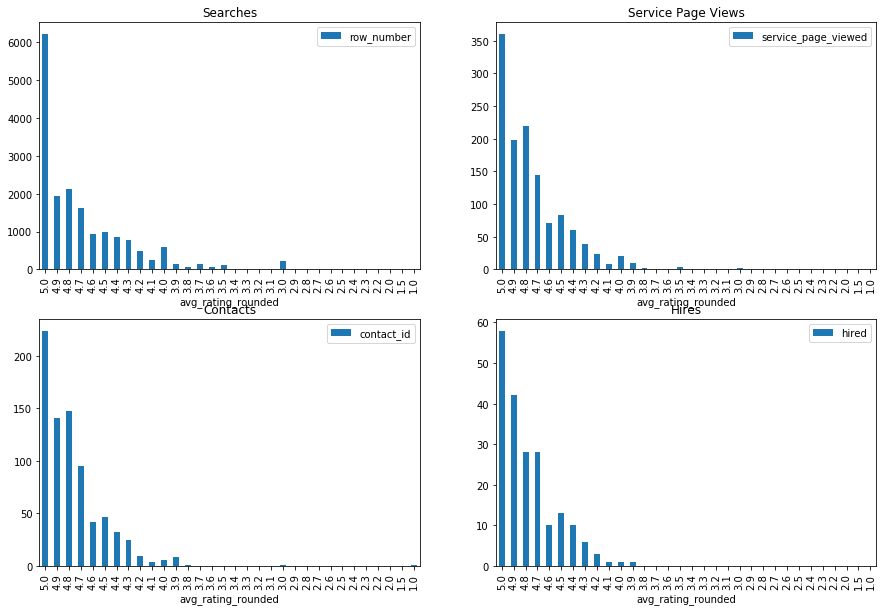

In [64]:
fig, axes = plt.subplots(2,2, figsize=(15,10))

cleaning_avg_rating[['avg_rating_rounded','row_number']].plot(kind='bar',
                                                             x='avg_rating_rounded',
                                                             y='row_number',
                                                             ax=axes[0,0],
                                                             title='Searches')

cleaning_avg_rating[['avg_rating_rounded','service_page_viewed']].plot(kind='bar',
                                                              x='avg_rating_rounded',
                                                              y='service_page_viewed',
                                                              ax=axes[0,1],
                                                              title='Service Page Views')

cleaning_avg_rating[['avg_rating_rounded','contact_id']].plot(kind='bar',
                                                             x='avg_rating_rounded',
                                                             y='contact_id',
                                                             ax=axes[1,0],
                                                             title='Contacts')

cleaning_avg_rating[['avg_rating_rounded','hired']].plot(kind='bar',
                                                        x='avg_rating_rounded',
                                                        y='hired',
                                                        ax=axes[1,1],
                                                        title='Hires')

### Contact rate (contacts/searches) by avg_rating

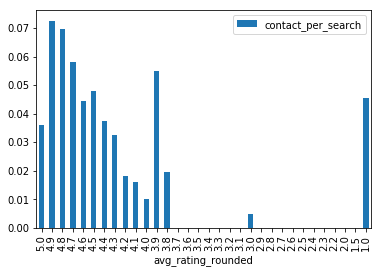

In [65]:
cleaning_avg_rating[['avg_rating_rounded','contact_per_search']].plot(kind='bar',
                                                                     x='avg_rating_rounded',
                                                                     y='contact_per_search')

## Cost Estimate

In [66]:
cleaning['cost_estimate_dollars'].describe()

count    16847.000000
mean       117.980293
std         47.348165
min          1.000000
25%         90.000000
50%        109.000000
75%        130.000000
max       1005.000000
Name: cost_estimate_dollars, dtype: float64

In [67]:
cleaning_cost = summarize_metric(cleaning, 'cost_estimate_dollars')
cost_bins = [i for i in range(0, 300, 5)]

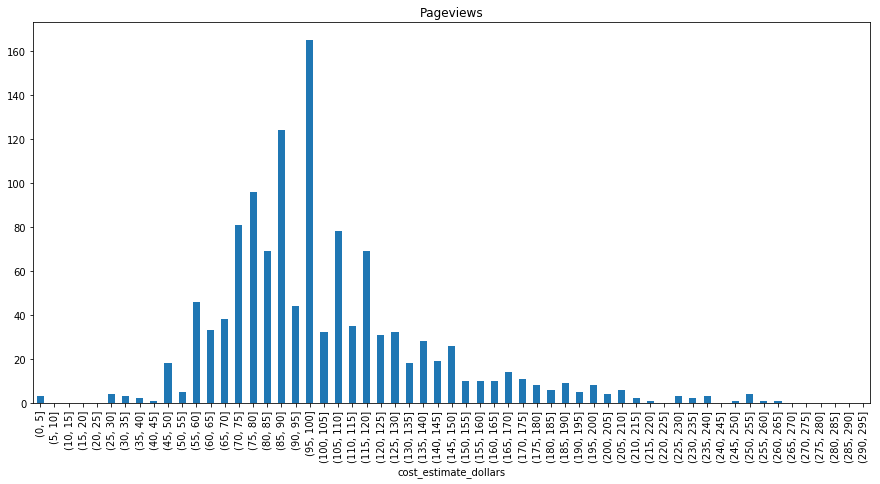

In [68]:
cleaning_page_views = cleaning_cost.groupby(pd.cut(cleaning_cost['cost_estimate_dollars'], bins=cost_bins)).service_page_viewed.sum()
cleaning_page_views.plot(kind='bar', figsize=(15,7), title='Pageviews')

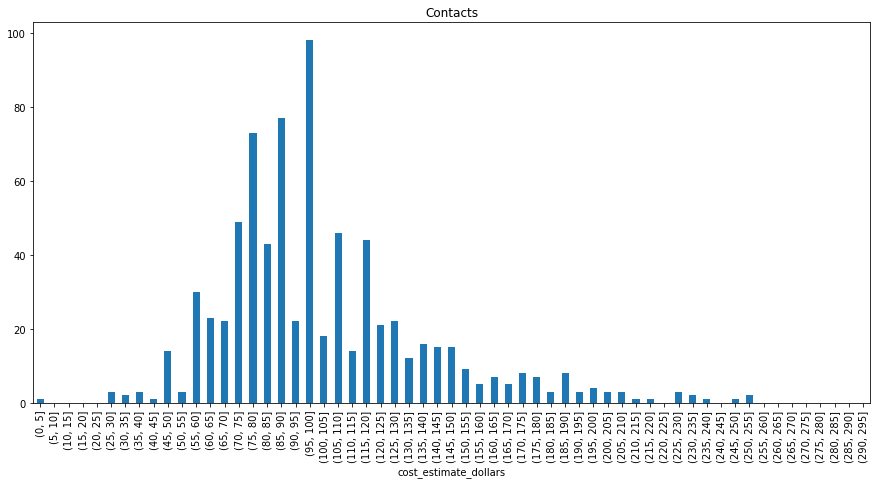

In [69]:
cleaning_contacts = cleaning_cost.groupby(pd.cut(cleaning_cost['cost_estimate_dollars'], bins=cost_bins)).contact_id.sum()
cleaning_contacts.plot(kind='bar', figsize=(15,7), title='Contacts')

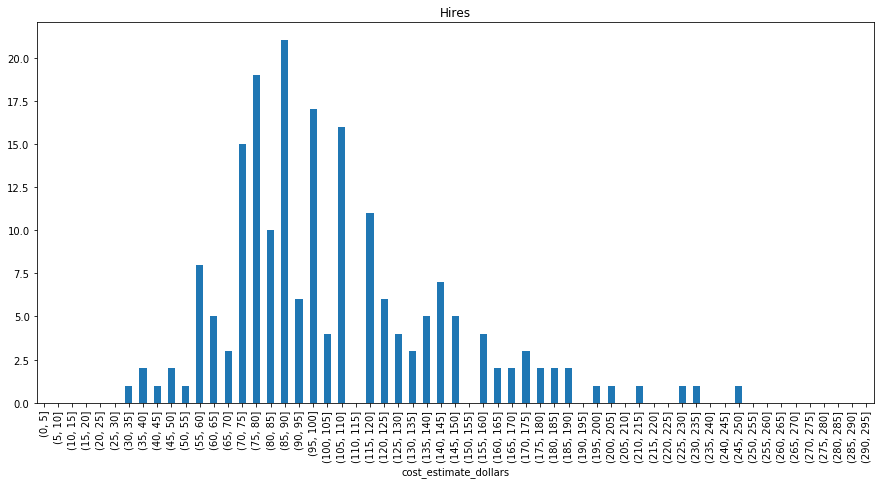

In [70]:
cleaning_hires = cleaning_cost.groupby(pd.cut(cleaning_cost['cost_estimate_dollars'], bins=cost_bins)).hired.sum()
cleaning_hires.plot(kind='bar', figsize=(15,7), title='Hires')

## result position

In [71]:
cleaning['result_position'].describe()

count    18149.000000
mean         8.238856
std          6.618836
min          1.000000
25%          3.000000
50%          6.000000
75%         12.000000
max         30.000000
Name: result_position, dtype: float64

In [72]:
cleaning['result_position'].isnull().sum()

0

In [73]:
cleaning_result_position = summarize_metric(cleaning, 'result_position', ascending=True)
cleaning_result_position

,result_position,row_number,service_page_viewed,contact_id,hired,%_of_searches,%_of_page_views,%_of_contacts,%_of_hires,page_view_per_search,contact_per_search,contact_per_page_view,hire_per_search,hire_per_contact
0,1,1878,518.0,379,99.0,0.103477,0.411111,0.477932,0.485294,0.275825,0.201810,0.731660,0.052716,0.261214
1,2,1767,273.0,172,44.0,0.097361,0.216667,0.216898,0.215686,0.154499,0.097340,0.630037,0.024901,0.255814
2,3,1633,143.0,84,22.0,0.089977,0.113492,0.105927,0.107843,0.087569,0.051439,0.587413,0.013472,0.261905
3,4,1469,101.0,48,13.0,0.080941,0.080159,0.060530,0.063725,0.068754,0.032675,0.475248,0.008850,0.270833
4,5,1323,64.0,36,11.0,0.072897,0.050794,0.045397,0.053922,0.048375,0.027211,0.562500,0.008314,0.305556
5,6,1188,42.0,18,3.0,0.065458,0.033333,0.022699,0.014706,0.035354,0.015152,0.428571,0.002525,0.166667
6,7,1054,43.0,16,4.0,0.058075,0.034127,0.020177,0.019608,0.040797,0.015180,0.372093,0.003795,0.250000
7,8,939,22.0,11,3.0,0.051738,0.017460,0.013871,0.014706,0.023429,0.011715,0.500000,0.003195,0.272727
8,9,840,21.0,12,4.0,0.046284,0.016667,0.015132,0.019608,0.025000,0.014286,0.571429,0.004762,0.333333
9,10,736,17.0,5,0.0,0.040553,0.013492,0.006305,0.000000,0.023098,0.006793,0.294118,0.000000,0.000000


### Searches, Pageviews, Contacts, Hires by result_position

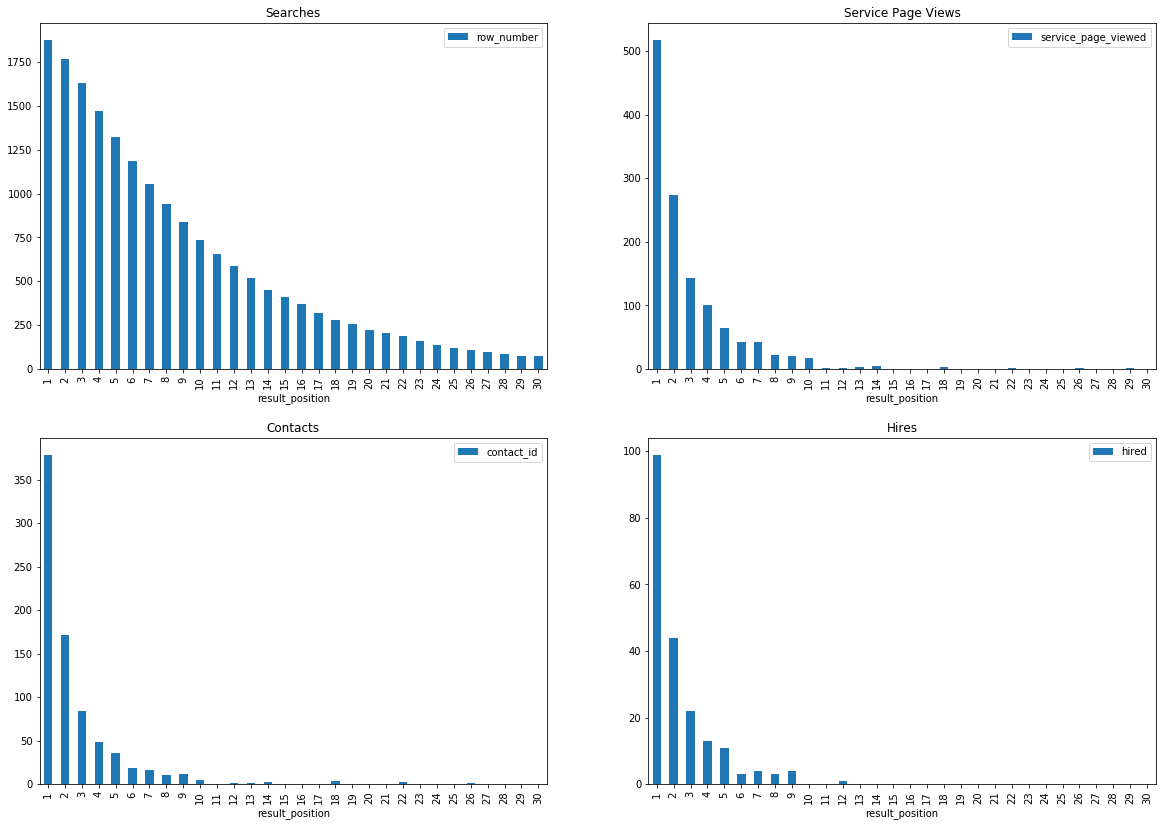

In [74]:
fig, axes = plt.subplots(2,2, figsize=(20,14))

cleaning_result_position[['result_position','row_number']].plot(kind='bar',
                                                                 x='result_position',
                                                                 y='row_number',
                                                                 ax=axes[0,0],
                                                                 title='Searches')

cleaning_result_position[['result_position','service_page_viewed']].plot(kind='bar',
                                                                          x='result_position',
                                                                          y='service_page_viewed',
                                                                          ax=axes[0,1],
                                                                          title='Service Page Views')

cleaning_result_position[['result_position','contact_id']].plot(kind='bar',
                                                                 x='result_position',
                                                                 y='contact_id',
                                                                 ax=axes[1,0],
                                                                 title='Contacts')

cleaning_result_position[['result_position','hired']].plot(kind='bar',
                                                            x='result_position',
                                                            y='hired',
                                                            ax=axes[1,1],
                                                            title='Hires')

## Rates by result_position

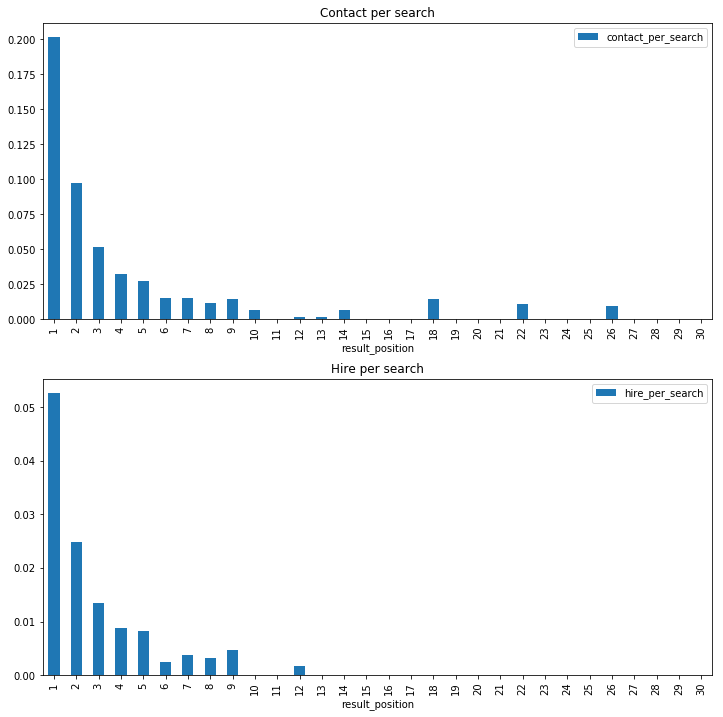

In [75]:
fig, axes = plt.subplots(2,1, figsize=(12,12))

cleaning_result_position[['result_position','contact_per_search']].plot(kind='bar',
                                                                         x='result_position',
                                                                         y='contact_per_search',
                                                                         ax=axes[0],
                                                                         title='Contact per search')

cleaning_result_position[['result_position','hire_per_search']].plot(kind='bar',
                                                                     x='result_position',
                                                                     y='hire_per_search',
                                                                     ax=axes[1],
                                                                     title='Hire per search')

### Responsiveness (in hours)


In [76]:
cleaning['last_active_hours'].describe()

count    18149.000000
mean       446.233071
std       1728.240562
min          1.000000
25%          7.000000
50%         28.000000
75%        117.000000
max      21981.000000
Name: last_active_hours, dtype: float64

In [77]:
cleaning_last_active_hours = summarize_metric(cleaning, 'last_active_hours', ascending=True)
cleaning_last_active_hours.head(20)

,last_active_hours,row_number,service_page_viewed,contact_id,hired,%_of_searches,%_of_page_views,%_of_contacts,%_of_hires,page_view_per_search,contact_per_search,contact_per_page_view,hire_per_search,hire_per_contact
0,1.0,1178,121.0,86,35.0,0.064907,0.096032,0.108449,0.171569,0.102716,0.073005,0.710744,0.029711,0.406977
1,2.0,955,93.0,64,25.0,0.052620,0.073810,0.080706,0.122549,0.097382,0.067016,0.688172,0.026178,0.390625
2,3.0,763,77.0,48,6.0,0.042041,0.061111,0.060530,0.029412,0.100917,0.062910,0.623377,0.007864,0.125000
3,4.0,634,67.0,44,10.0,0.034933,0.053175,0.055485,0.049020,0.105678,0.069401,0.656716,0.015773,0.227273
4,5.0,475,48.0,32,11.0,0.026172,0.038095,0.040353,0.053922,0.101053,0.067368,0.666667,0.023158,0.343750
5,6.0,380,35.0,20,5.0,0.020938,0.027778,0.025221,0.024510,0.092105,0.052632,0.571429,0.013158,0.250000
6,7.0,300,29.0,18,5.0,0.016530,0.023016,0.022699,0.024510,0.096667,0.060000,0.620690,0.016667,0.277778
7,8.0,261,21.0,13,3.0,0.014381,0.016667,0.016393,0.014706,0.080460,0.049808,0.619048,0.011494,0.230769
8,9.0,239,19.0,7,0.0,0.013169,0.015079,0.008827,0.000000,0.079498,0.029289,0.368421,0.000000,0.000000
9,10.0,209,18.0,10,2.0,0.011516,0.014286,0.012610,0.009804,0.086124,0.047847,0.555556,0.009569,0.200000


In [78]:
cleaning_last_active_hours[cleaning_last_active_hours['last_active_hours'] <= 28]['%_of_contacts'].sum()

0.6393442622950819

### number of reviews

In [79]:
cleaning['num_reviews'].describe()

count    18149.000000
mean        30.903631
std         57.225607
min          0.000000
25%          4.000000
50%         10.000000
75%         33.000000
max        616.000000
Name: num_reviews, dtype: float64

In [80]:
cleaning_num_reviews = summarize_metric(cleaning, 'num_reviews')

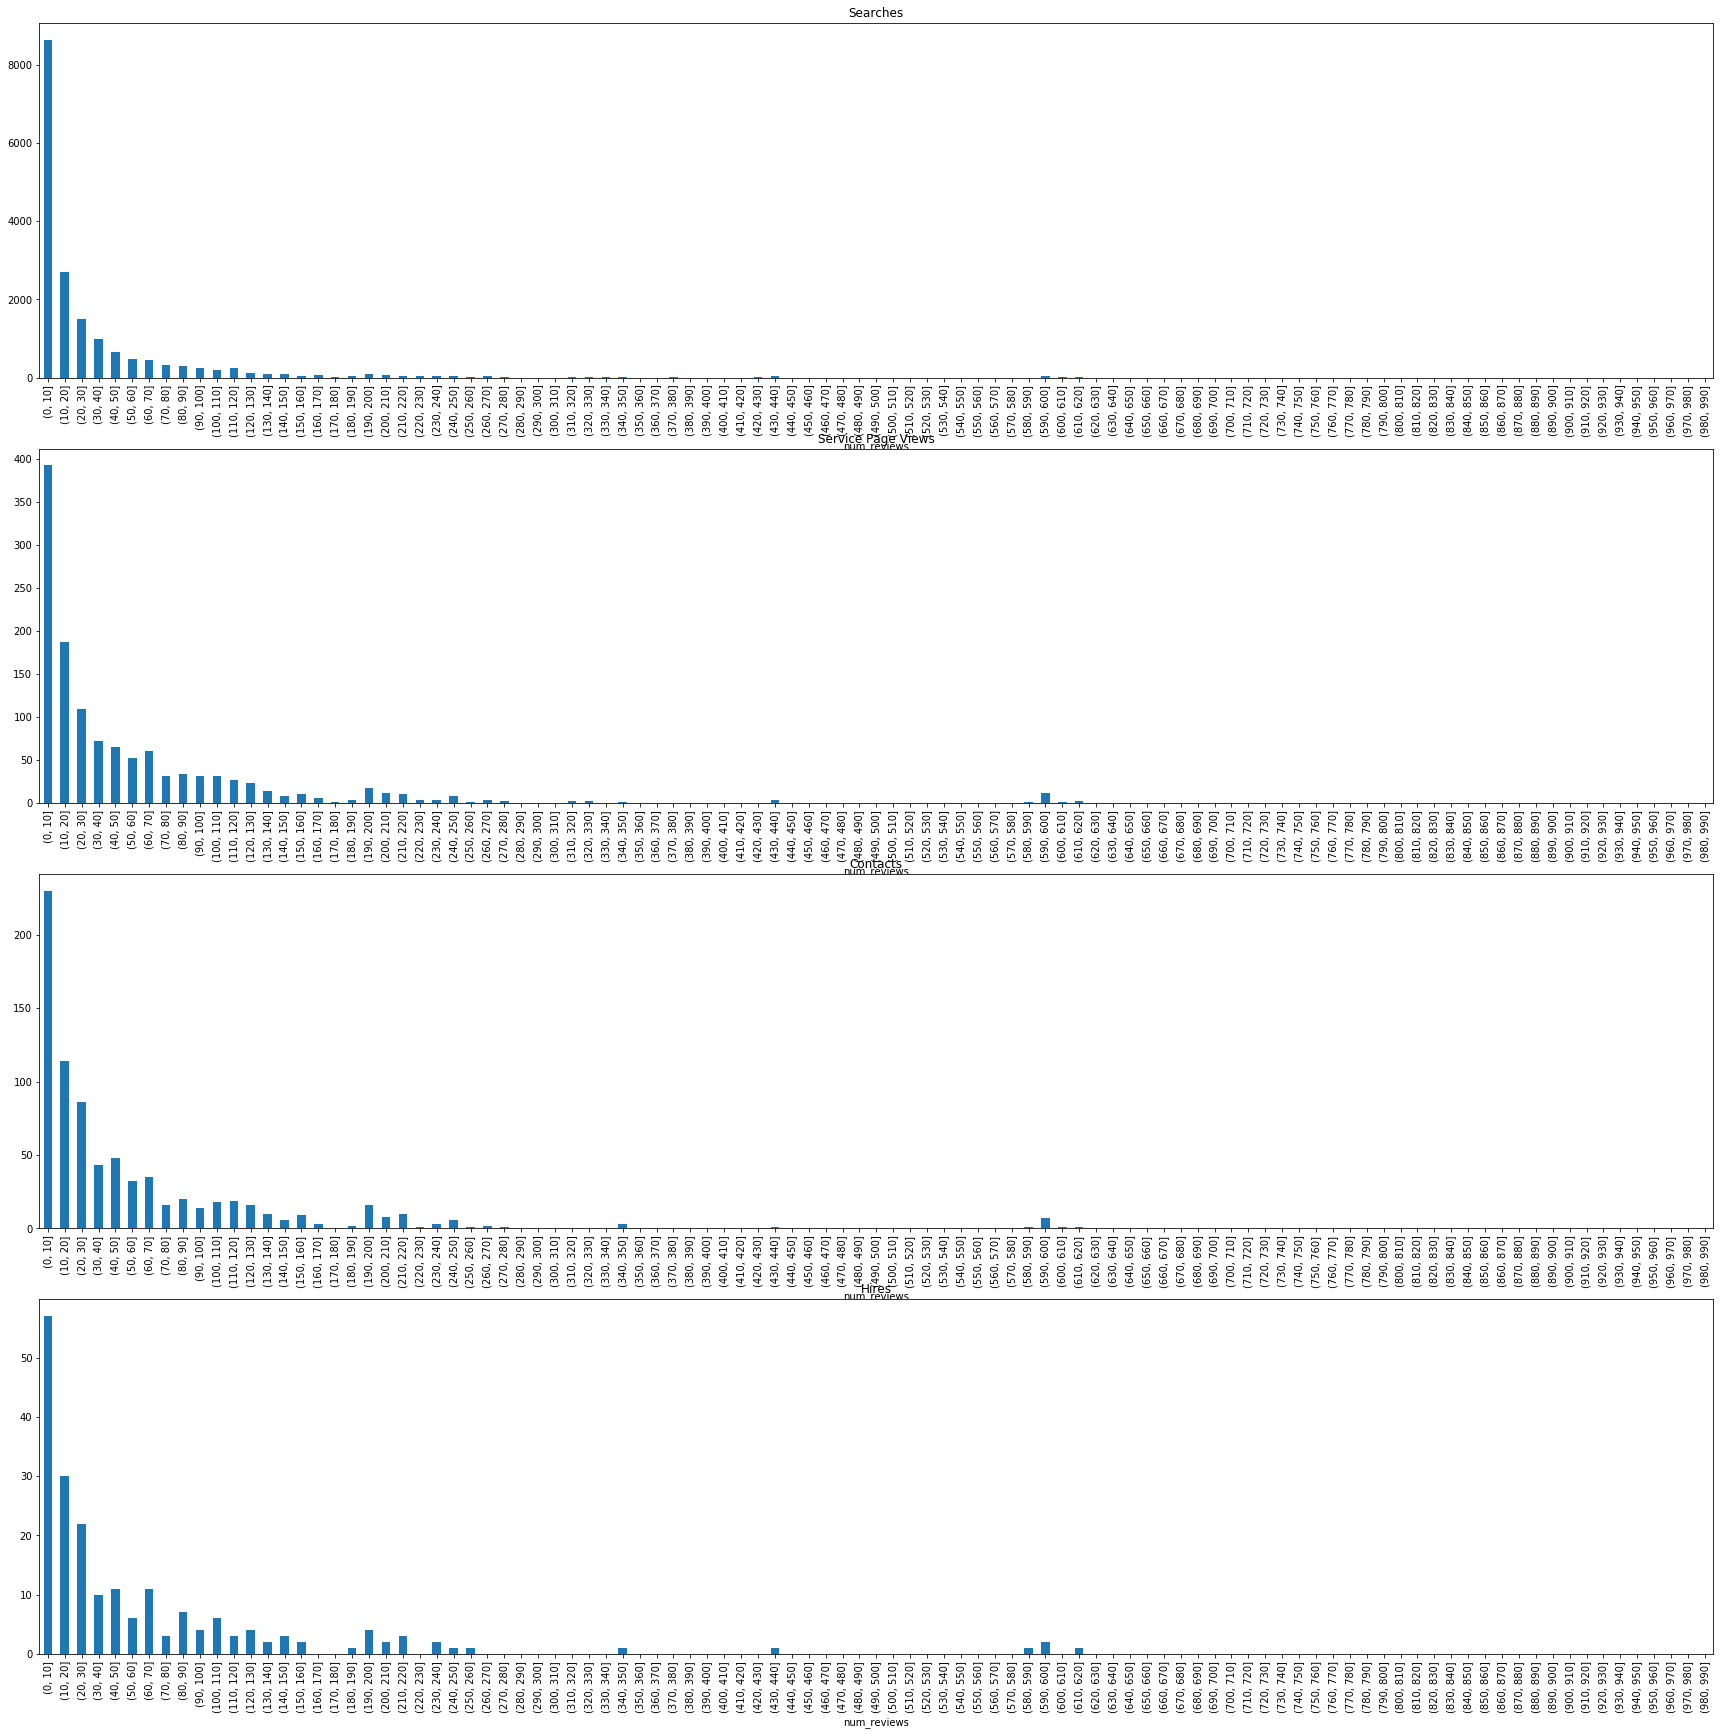

In [81]:
review_bins = [i for i in range(0, 1000, 10)]
fig, axes = plt.subplots(4,1, figsize=(30,30))

cleaning_searches = cleaning_num_reviews.groupby(pd.cut(cleaning_num_reviews['num_reviews'], bins=review_bins)).row_number.sum()
cleaning_searches.plot(kind='bar', ax=axes[0], title='Searches')

cleaning_page_views = cleaning_num_reviews.groupby(pd.cut(cleaning_num_reviews['num_reviews'], bins=review_bins)).service_page_viewed.sum()
cleaning_page_views.plot(kind='bar', ax=axes[1], title='Service Page Views')

cleaning_contacts = cleaning_num_reviews.groupby(pd.cut(cleaning_num_reviews['num_reviews'], bins=review_bins)).contact_id.sum()
cleaning_contacts.plot(kind='bar', ax=axes[2], title='Contacts')

cleaning_hires = cleaning_num_reviews.groupby(pd.cut(cleaning_num_reviews['num_reviews'], bins=review_bins)).hired.sum()
cleaning_hires.plot(kind='bar', ax=axes[3], title='Hires')


### Data Model - Hires

In [82]:
hired = cleaning['hired']
features = cleaning[['num_reviews',
                       'avg_rating',
                       'cost_estimate_dollars',
                       'result_position',
                       'last_active_hours']].fillna(0)

In [83]:
X_train, X_test, y_train, y_test = train_test_split(features, hired,train_size = 0.8, random_state = 0)
rfc = RandomForestClassifier(n_estimators=10)
rfc_model = rfc.fit(X_train, y_train)
rfc_predictions = rfc_model.predict(X_test)

scores(y_test, rfc_predictions)

Accuracy score: 0.9878787878787879
F1 score: [0.99390244 0.        ]
Precision score: [0.98978747 0.        ]
Recall score: [0.99805177 0.        ]


/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [84]:
feature_importances = pd.DataFrame(rfc.feature_importances_,
                                   index = X_train.columns,
                                   columns=['importance']).sort_values('importance',ascending=False)
feature_importances

,importance
num_reviews,0.240311
last_active_hours,0.228017
avg_rating,0.223675
cost_estimate_dollars,0.220626
result_position,0.087371


### Contacts

In [85]:
contacts = cleaning['contact_id'].notnull()

In [86]:
X_train, X_test, y_train, y_test = train_test_split(features, contacts, train_size = 0.8)
rfc = RandomForestClassifier(n_estimators=10)
rfc_model = rfc.fit(X_train, y_train)
rfc_predictions = rfc_model.predict(X_test)
scores(y_test, rfc_predictions)
feature_importances = pd.DataFrame(rfc.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Accuracy score: 0.9534435261707989
F1 score: [0.97612657 0.06629834]
Precision score: [0.96159198 0.16216216]
Recall score: [0.99110729 0.04166667]


,importance
last_active_hours,0.275268
num_reviews,0.208302
cost_estimate_dollars,0.201820
avg_rating,0.189859
result_position,0.124751


### Pageviews

In [87]:
pageviews = cleaning['service_page_viewed']

In [88]:
X_train, X_test, y_train, y_test = train_test_split(features, pageviews, train_size = 0.8)
rfc = RandomForestClassifier(n_estimators=10)
rfc_model = rfc.fit(X_train, y_train)
rfc_predictions = rfc_model.predict(X_test)
scores(y_test, rfc_predictions)
feature_importances = pd.DataFrame(rfc.feature_importances_,
                                   index = X_train.columns,
                                   columns=['importance']).sort_values('importance',ascending=False)
feature_importances

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Accuracy score: 0.9206611570247933
F1 score: [0.95850144 0.1       ]
Precision score: [0.93426966 0.22857143]
Recall score: [0.98402367 0.064     ]


,importance
last_active_hours,0.285587
cost_estimate_dollars,0.197368
num_reviews,0.189562
avg_rating,0.184058
result_position,0.143425
